In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
plt.style.use ('ggplot')
import seaborn as sns
%matplotlib inline
sns.set_style(style="whitegrid")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text

from bs4 import BeautifulSoup

import nltk, string, contractions

from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel

from operator import itemgetter

In [2]:
df = pd.read_csv('data/modeling_ready_microwave1')

In [14]:
df.dropna(inplace=True)

In [31]:
df['token'] = df['model_ready'].str.split()

In [16]:
def topic_modeler(max_features=5000, min_df=2, max_df=.85, topic_max = 20, topic_step = 1):
    # Use Gensim's NMF to get the best num of topics via coherence score
    texts = df['model_ready'].str.split()

    # Create a dictionary
    # In gensim a dictionary is a mapping between words and their integer id
    dictionary = Dictionary(texts)

    # Filter out extremes to limit the number of features
    dictionary.filter_extremes(
        no_below=min_df,
        no_above=max_df,
        keep_n=max_features
    )

    # Create the bag-of-words format (list of (token_id, token_count))
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Create a list of the topic numbers we want to try
    topic_nums = list(np.arange(1, topic_max + 1, topic_step))

    # Run the nmf model and calculate the coherence score
    # for each number of topics
    coherence_scores = []

    for num in topic_nums:
        gs_nmf = Nmf(
            corpus=corpus,
            num_topics=num,
            id2word=dictionary,
            chunksize=2000,
            passes=5,
            kappa=.1,
            minimum_probability=0.01,
            w_max_iter=300,
            w_stop_condition=0.0001,
            h_max_iter=100,
            h_stop_condition=0.001,
            eval_every=10,
            normalize=True,
            random_state=12345
        )

        # Run the coherence model to get the score
        cm = CoherenceModel(
            model=gs_nmf,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )

        coherence_scores.append(round(cm.get_coherence(), 5))

    # Get the number of topics with the highest coherence score
    scores = list(zip(topic_nums, coherence_scores))
    best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]
    
#     if len(coherence_scores) == topic_max:
    fig, ax = plt.subplots(figsize=(14,8))
    plt.xlabel('Model Params: max_features = '+str(max_features)+',    min_df '+str(min_df)
               +',    max_df '+str(max_df))
    plt.ylabel('Coherence Score')
    plt.plot(range(0,topic_max), coherence_scores)
    plt.xticks(np.arange(0, topic_max, step=1))
    plt.yticks(np.arange(.37,.5,step=.01))
    plt.show()

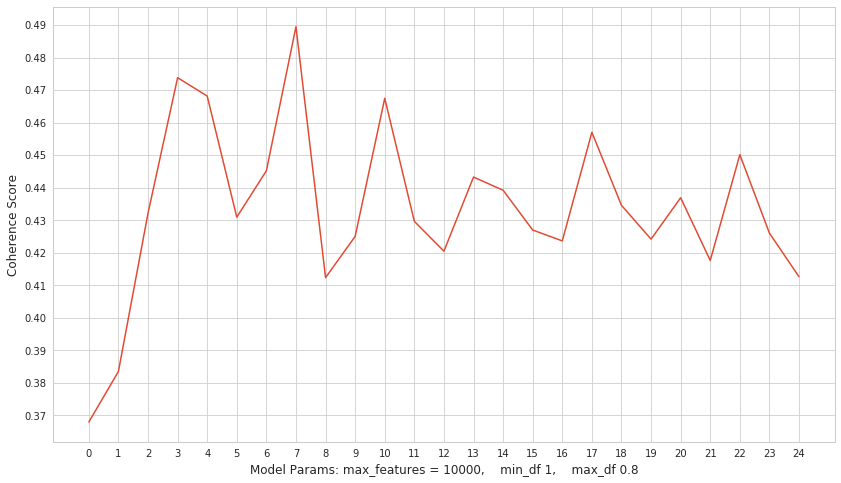

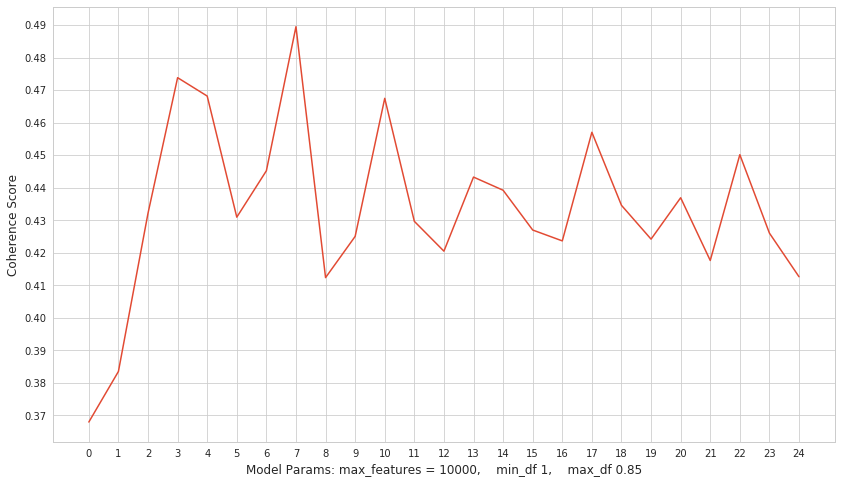

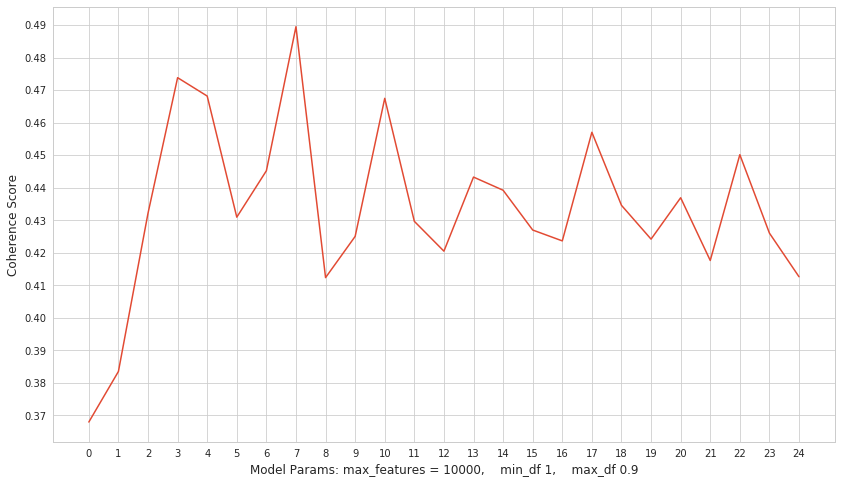

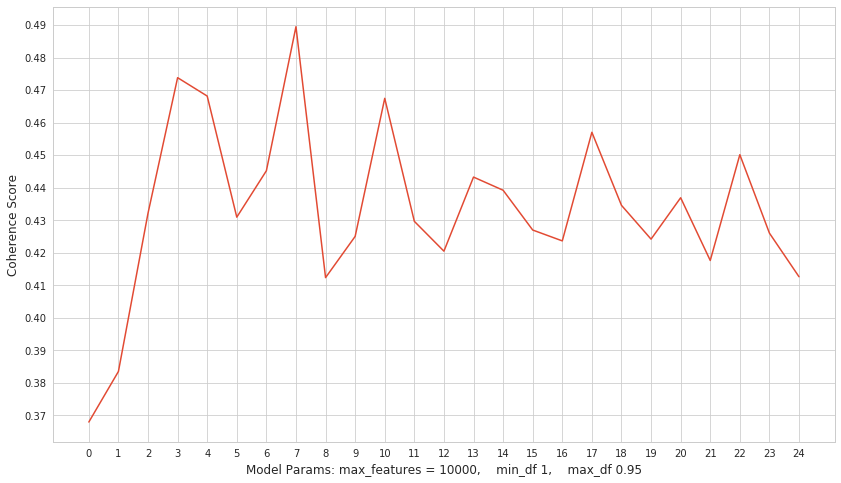

In [17]:
topic_modeler(10000, 1,.8,25, 1)
topic_modeler(10000, 1,.85,25, 1)
topic_modeler(10000, 1,.9,25, 1)
topic_modeler(10000, 1,.95,25, 1)

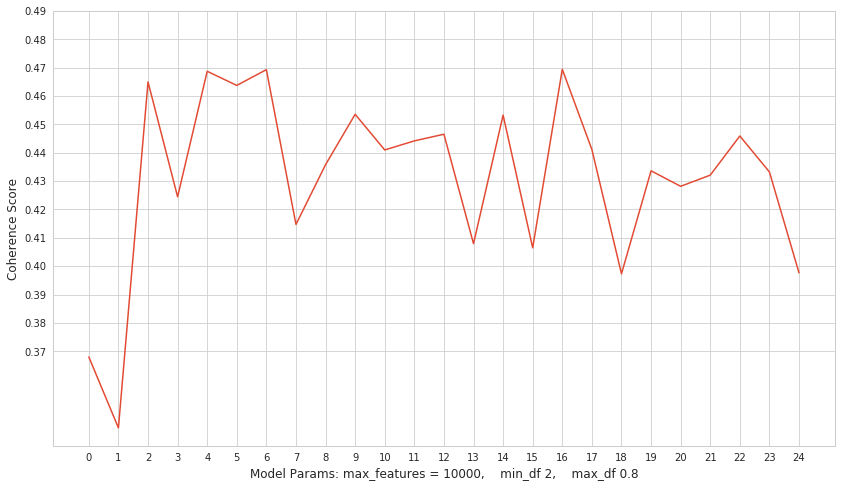

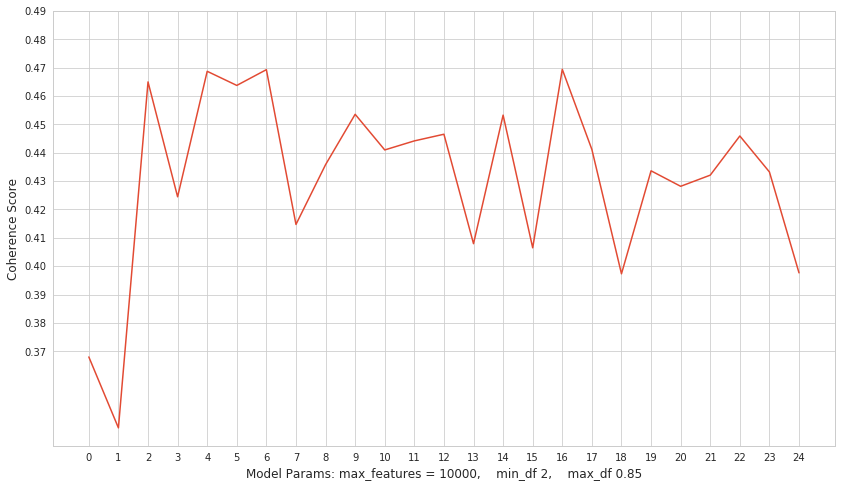

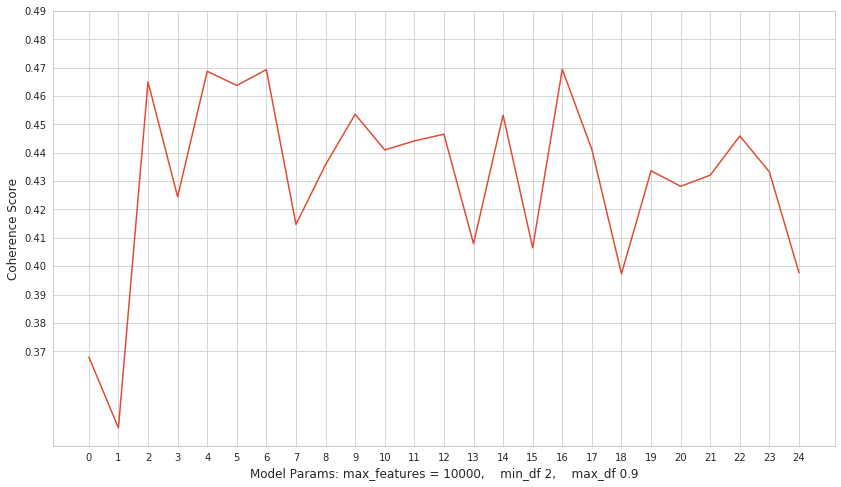

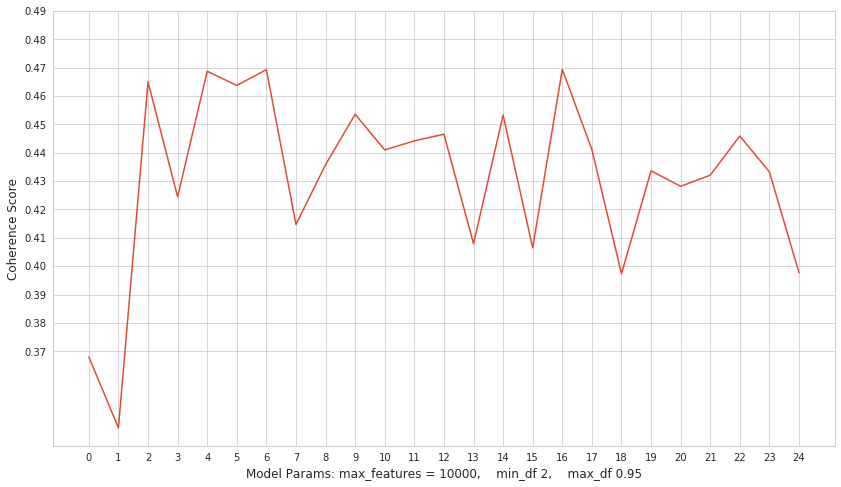

In [18]:
topic_modeler(10000, 2,.8,25, 1)
topic_modeler(10000, 2,.85,25, 1)
topic_modeler(10000, 2,.9,25, 1)
topic_modeler(10000, 2,.95,25, 1)

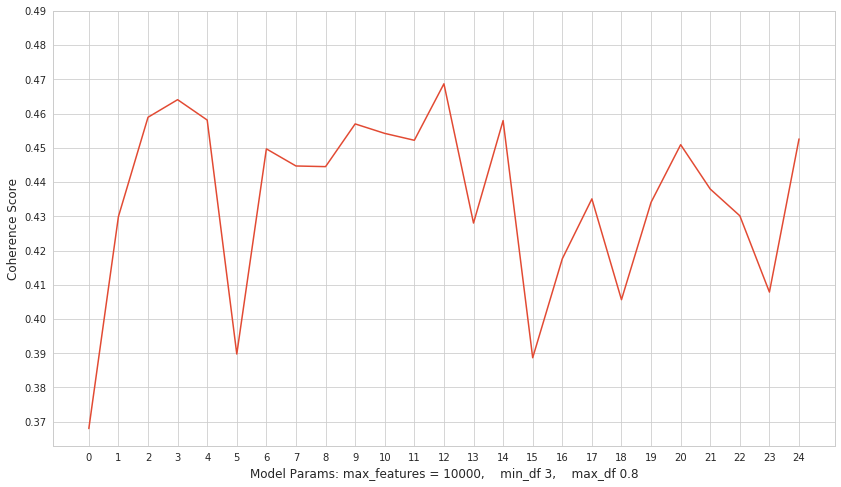

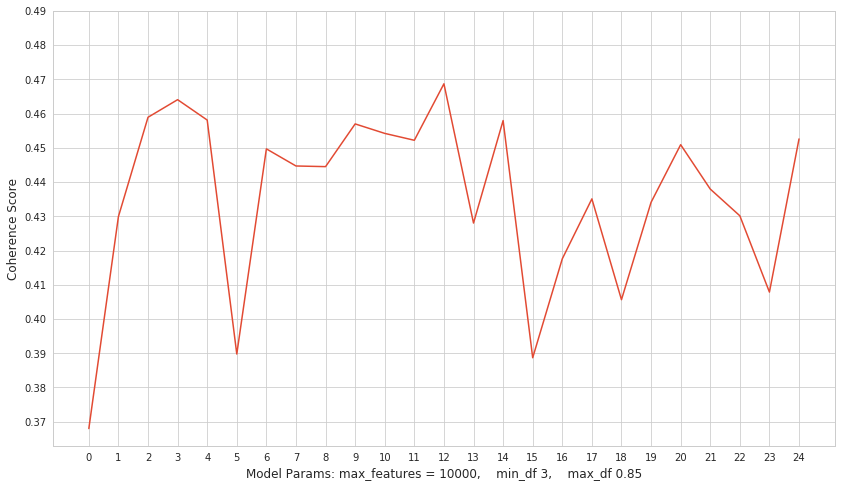

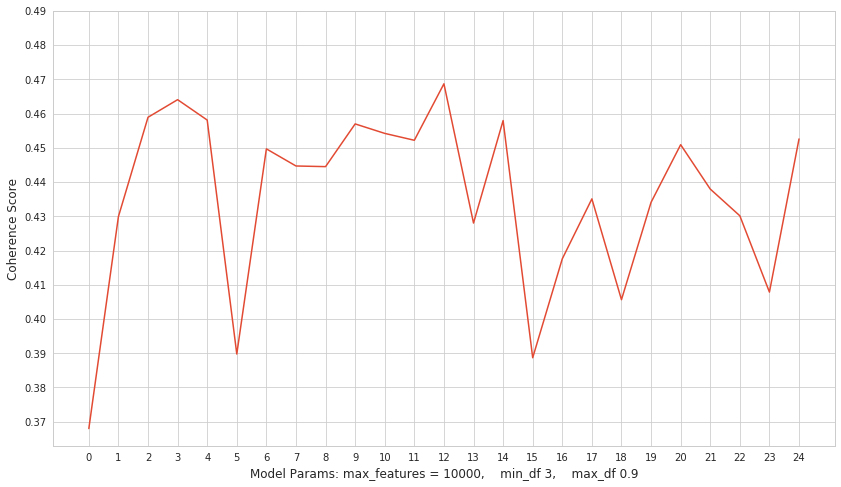

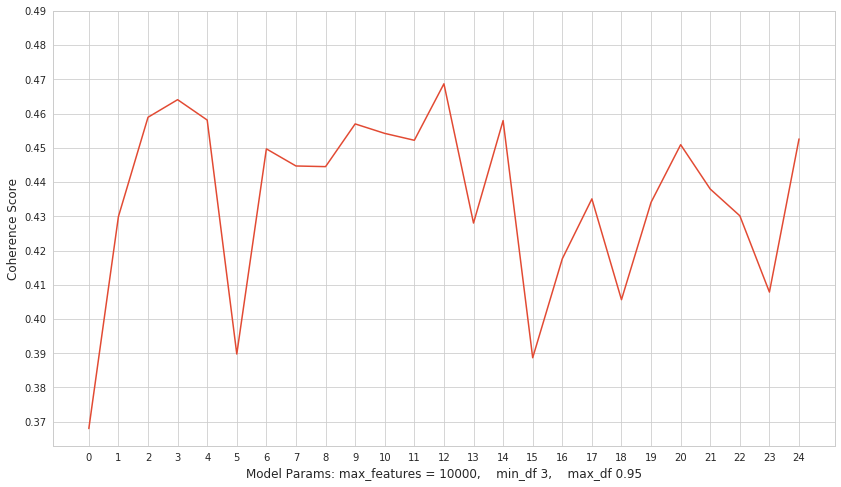

In [19]:
topic_modeler(10000, 3,.8,25, 1)
topic_modeler(10000, 3,.85,25, 1)
topic_modeler(10000, 3,.9,25, 1)
topic_modeler(10000, 3,.95,25, 1)

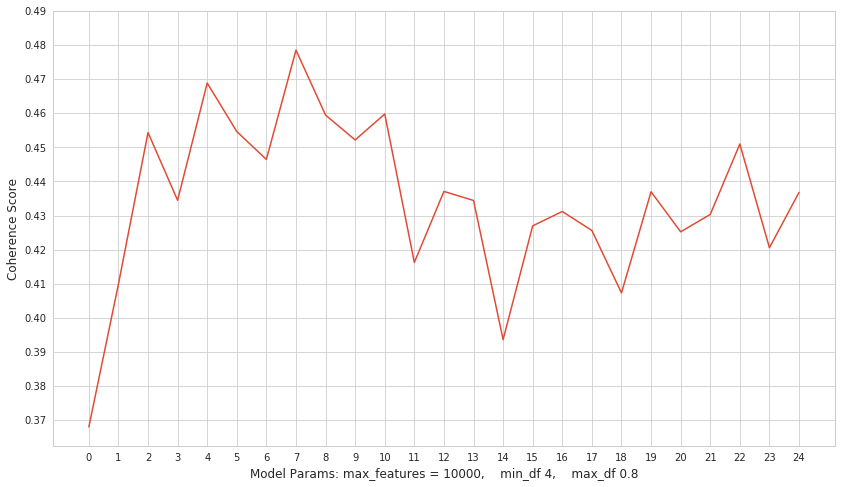

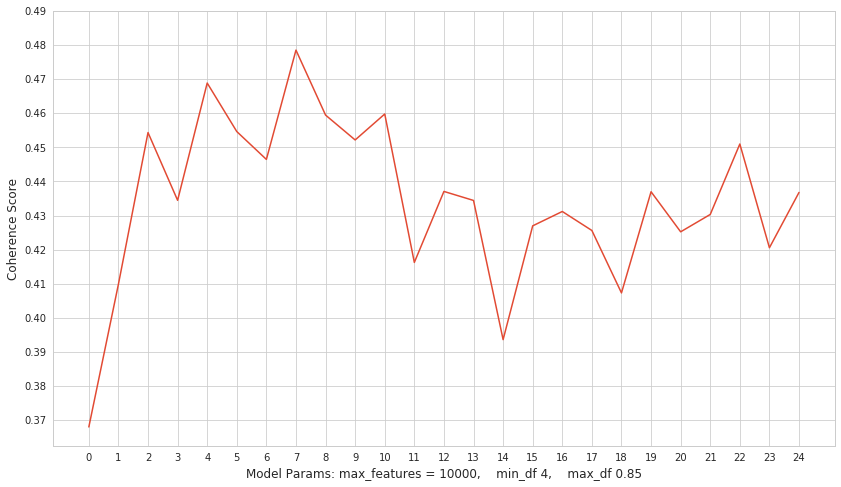

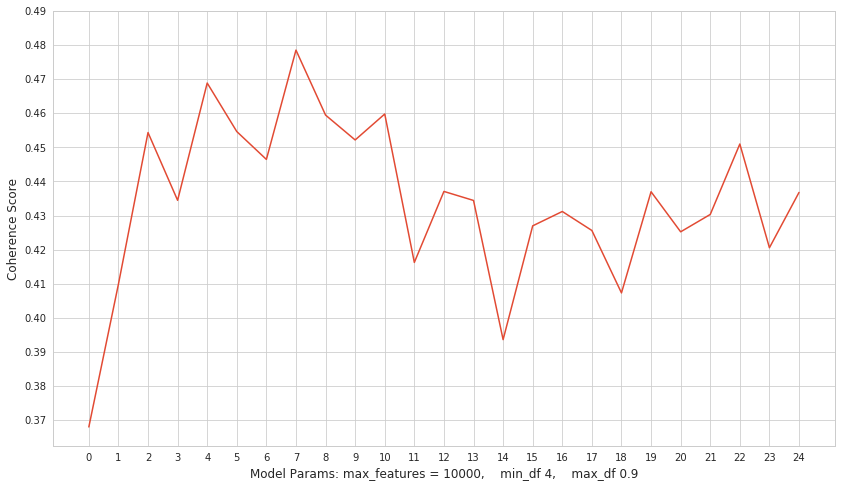

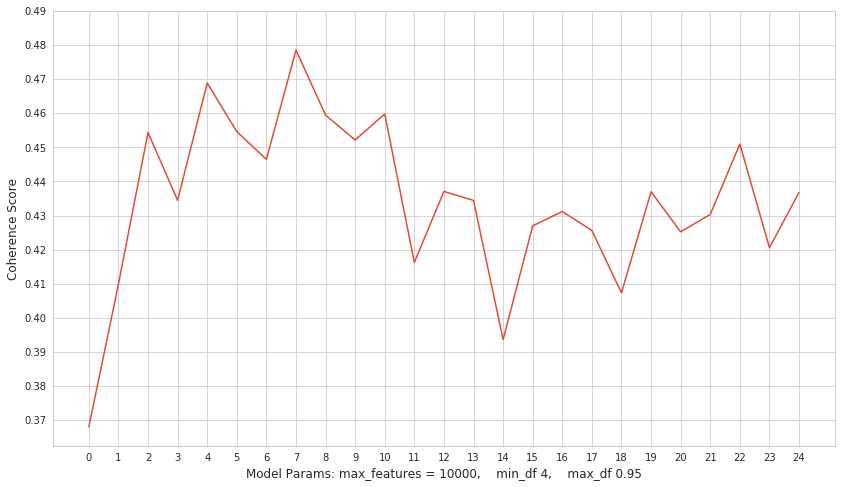

In [20]:
topic_modeler(10000, 4,.8,25, 1)
topic_modeler(10000, 4,.85,25, 1)
topic_modeler(10000, 4,.9,25, 1)
topic_modeler(10000, 4,.95,25, 1)

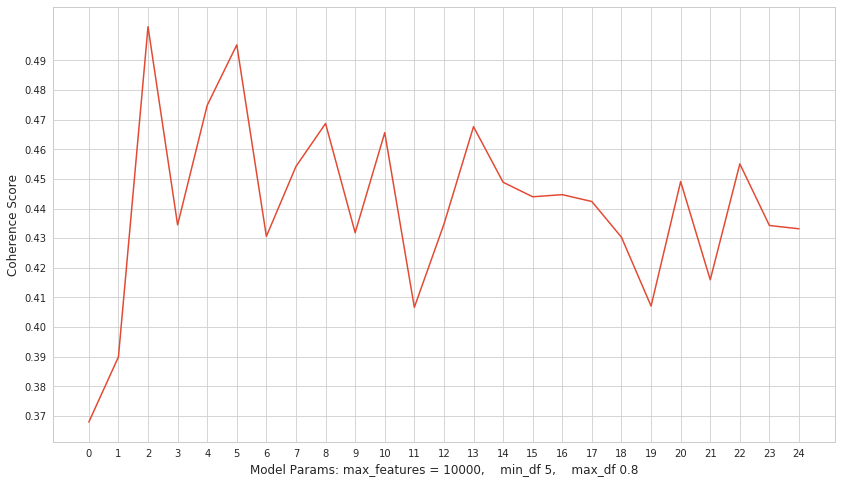

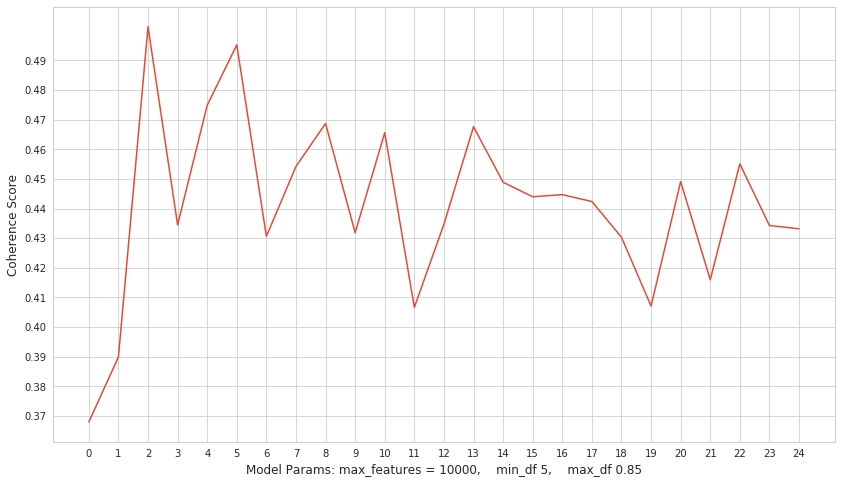

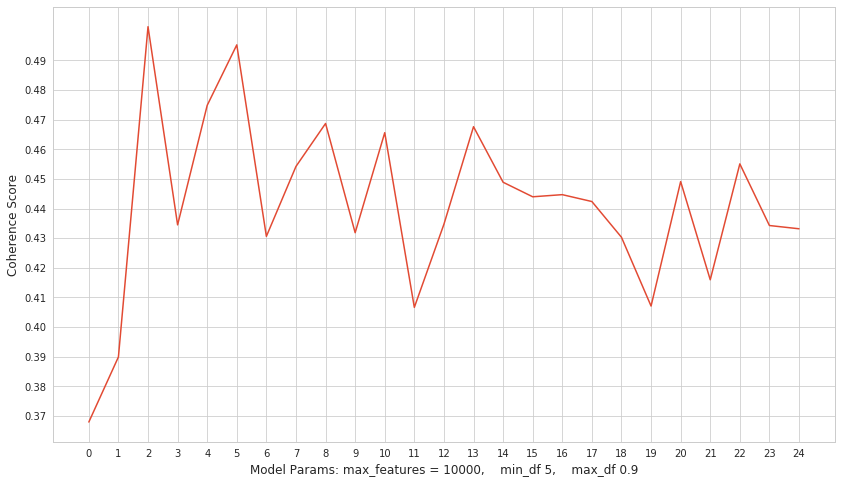

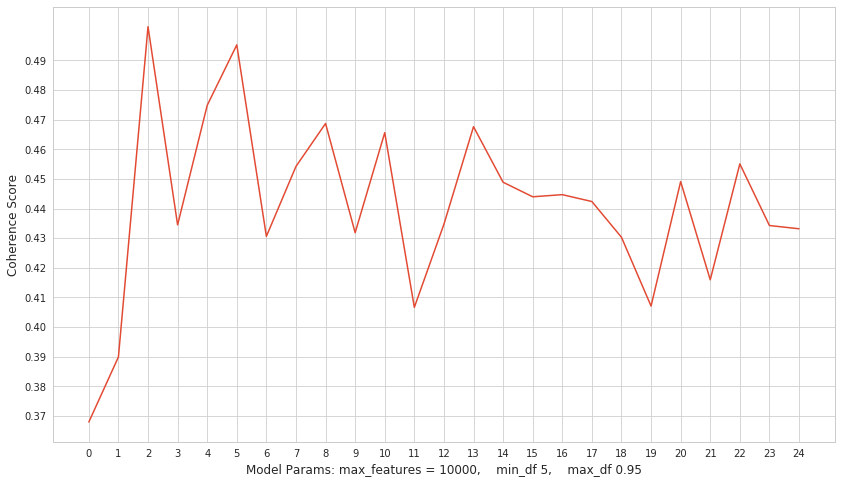

In [21]:
topic_modeler(10000, 5,.8,25, 1)
topic_modeler(10000, 5,.85,25, 1)
topic_modeler(10000, 5,.9,25, 1)
topic_modeler(10000, 5,.95,25, 1)

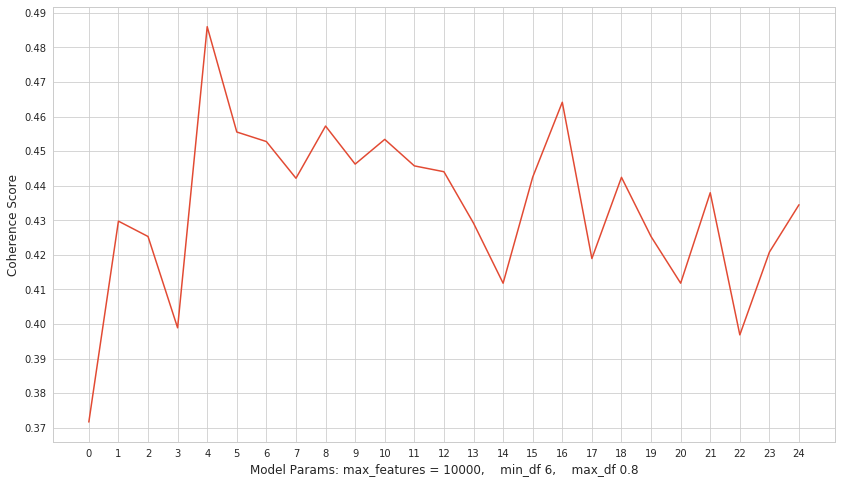

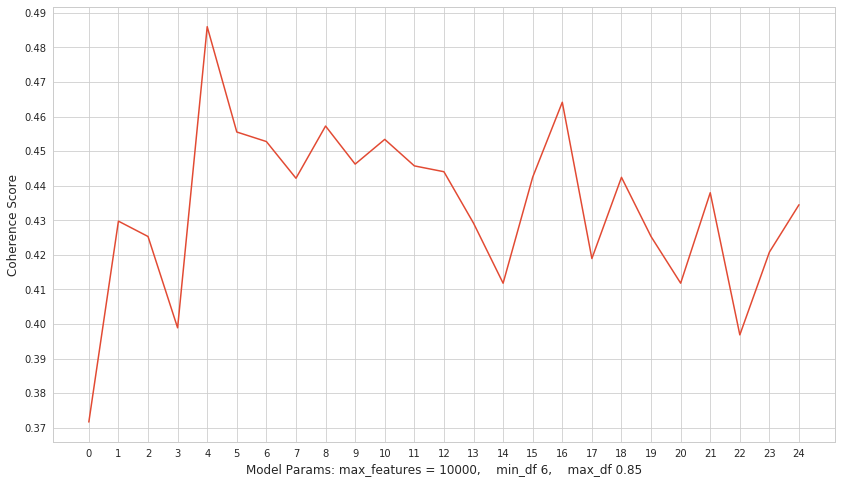

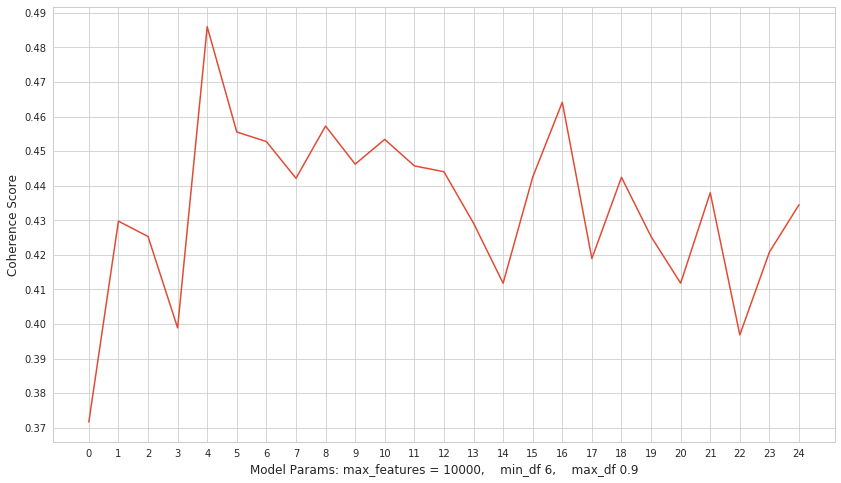

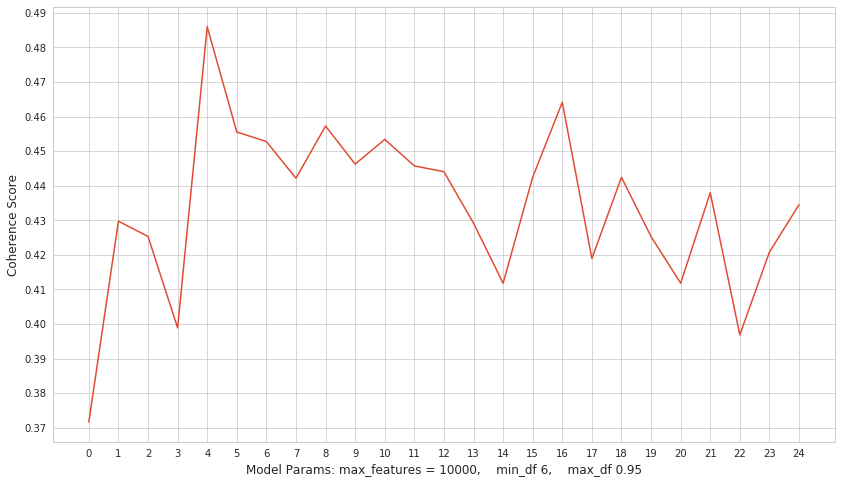

In [22]:
topic_modeler(10000, 6,.8,25, 1)
topic_modeler(10000, 6,.85,25, 1)
topic_modeler(10000, 6,.9,25, 1)
topic_modeler(10000, 6,.95,25, 1)